In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import numpy as np

In [2]:
df = pd.read_csv("customer_booking.csv", encoding="ISO-8859-1")
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


The `.head()` method allows us to view the first 5 rows in the dataset, this is useful for visual inspection of our columns

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 



To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion

**Feature Engineering** 

Creates new predictors to enhance model accuracy

In [7]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [8]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [9]:
df["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5], dtype=int64)

In [10]:
df["sales_channel"].unique()

array(['Internet', 'Mobile'], dtype=object)

In [11]:
sales_channel_mapping = {
    "Internet":1, "Mobile":2}
df["sales_channel"] = df["sales_channel"].map(sales_channel_mapping)
df["sales_channel"].unique()

array([1, 2], dtype=int64)

In [12]:
df["trip_type"].unique()

array(['RoundTrip', 'CircleTrip', 'OneWay'], dtype=object)

In [13]:
trip_type_mapping = {
    "RoundTrip":1, "CircleTrip":2, "OneWay":3}
df["trip_type"] = df["trip_type"].map(trip_type_mapping)
df["trip_type"].unique()

array([1, 2, 3], dtype=int64)

In [14]:
le_route = LabelEncoder()
df['route_encoded'] = le_route.fit_transform(df['route'])

le_origin = LabelEncoder()
df['booking_origin_encoded'] = le_origin.fit_transform(df['booking_origin'])


In [15]:
# new feature extraction: long route flight if flight_duration is more that 5 hours 
df['is_long_route'] = df['flight_duration'].apply(lambda x: 1 if x > 5 else 0)

In [16]:
# new feature extraction: AM flight if flight_hour is less than 12, else PM
df['IS_AM'] = np.where(df['flight_hour'] < 12, 1, 0)

In [17]:
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete,route_encoded,booking_origin_encoded,is_long_route,IS_AM
0,2,1,1,262,19,7,6,AKLDEL,New Zealand,1,0,0,5.52,0,0,61,1,1
1,1,1,1,112,20,3,6,AKLDEL,New Zealand,0,0,0,5.52,0,0,61,1,1
2,2,1,1,243,22,17,3,AKLDEL,India,1,1,0,5.52,0,0,36,1,0
3,1,1,1,96,31,4,6,AKLDEL,New Zealand,0,0,1,5.52,0,0,61,1,1
4,2,1,1,68,22,15,3,AKLDEL,India,1,0,1,5.52,0,0,36,1,0


In [18]:
df.describe()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete,route_encoded,booking_origin_encoded,is_long_route,IS_AM
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,1.112360,1.017800,84.940480,23.04456,9.06634,3.814420,0.668780,0.296960,0.427140,7.277561,0.149560,391.905800,38.263340,0.902060,0.665740
std,1.020165,0.315812,0.181559,90.451378,33.88767,5.41266,1.992792,0.470657,0.456923,0.494668,1.496863,0.356643,227.297259,32.756539,0.297236,0.471736
min,1.000000,1.000000,1.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.000000,0.000000,4.670000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,21.000000,5.00000,5.00000,2.000000,0.000000,0.000000,0.000000,5.620000,0.000000,203.000000,4.000000,1.000000,0.000000
50%,1.000000,1.000000,1.000000,51.000000,17.00000,9.00000,4.000000,1.000000,0.000000,0.000000,7.570000,0.000000,381.000000,37.000000,1.000000,1.000000
75%,2.000000,1.000000,1.000000,115.000000,28.00000,13.00000,5.000000,1.000000,1.000000,1.000000,8.830000,0.000000,611.000000,57.000000,1.000000,1.000000
max,9.000000,2.000000,3.000000,867.000000,778.00000,23.00000,7.000000,1.000000,1.000000,1.000000,9.500000,1.000000,798.000000,103.000000,1.000000,1.000000


**Data Visualization**

  Generates insightful charts and graphs to explore customer booking patterns, highlight key trends, and illustrate feature importance for model interpretation.

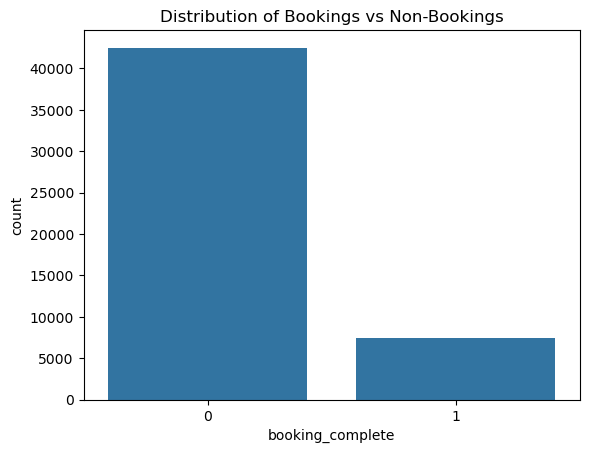

In [20]:
sns.countplot(x='booking_complete', data=df)
plt.title("Distribution of Bookings vs Non-Bookings")
plt.show()

C:\Users\abcha\AppData\Local\Temp\ipykernel_22000\2943402969.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df.groupby(['purchase_lead_bin', 'booking_complete']).size().unstack(fill_value=0)


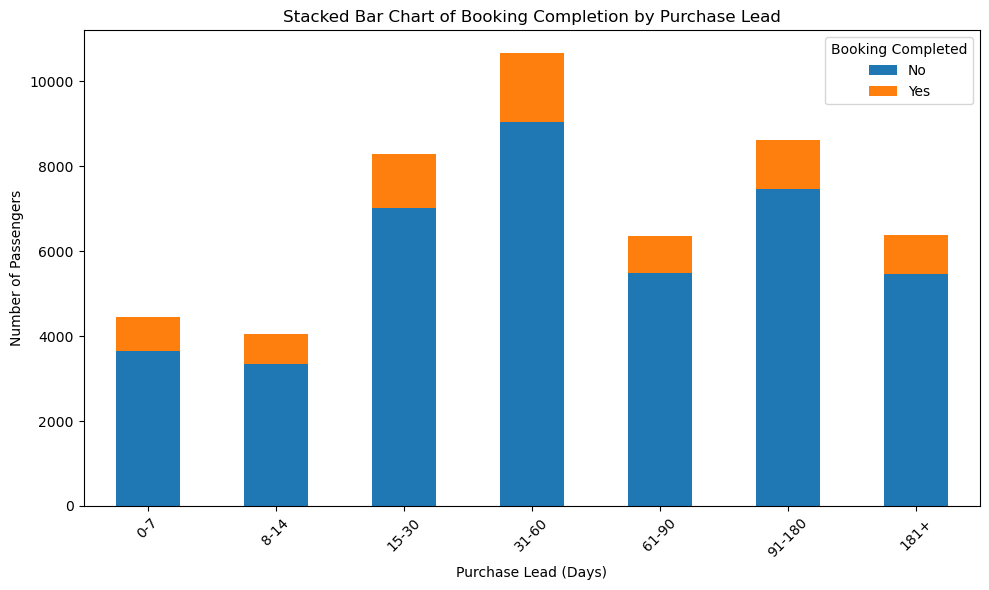

In [21]:
df['purchase_lead_bin'] = pd.cut(df['purchase_lead'], bins=[0,7,14,30,60,90,180,365],
                                 labels=['0-7','8-14','15-30','31-60','61-90','91-180','181+'])

counts = df.groupby(['purchase_lead_bin', 'booking_complete']).size().unstack(fill_value=0)


counts.plot(kind='bar', stacked=True, color=['#1f77b4', '#ff7f0e'], figsize=(10,6))
plt.title("Stacked Bar Chart of Booking Completion by Purchase Lead")
plt.xlabel("Purchase Lead (Days)")
plt.ylabel("Number of Passengers")
plt.legend(title='Booking Completed', labels=['No', 'Yes'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


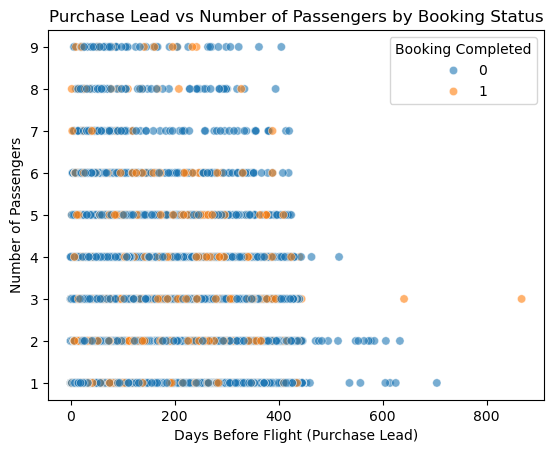

In [22]:
sns.scatterplot(data=df, x='purchase_lead', y='num_passengers', 
                hue='booking_complete', alpha=0.6)
plt.title("Purchase Lead vs Number of Passengers by Booking Status")
plt.xlabel("Days Before Flight (Purchase Lead)")
plt.ylabel("Number of Passengers")
plt.legend(title='Booking Completed')
plt.show()


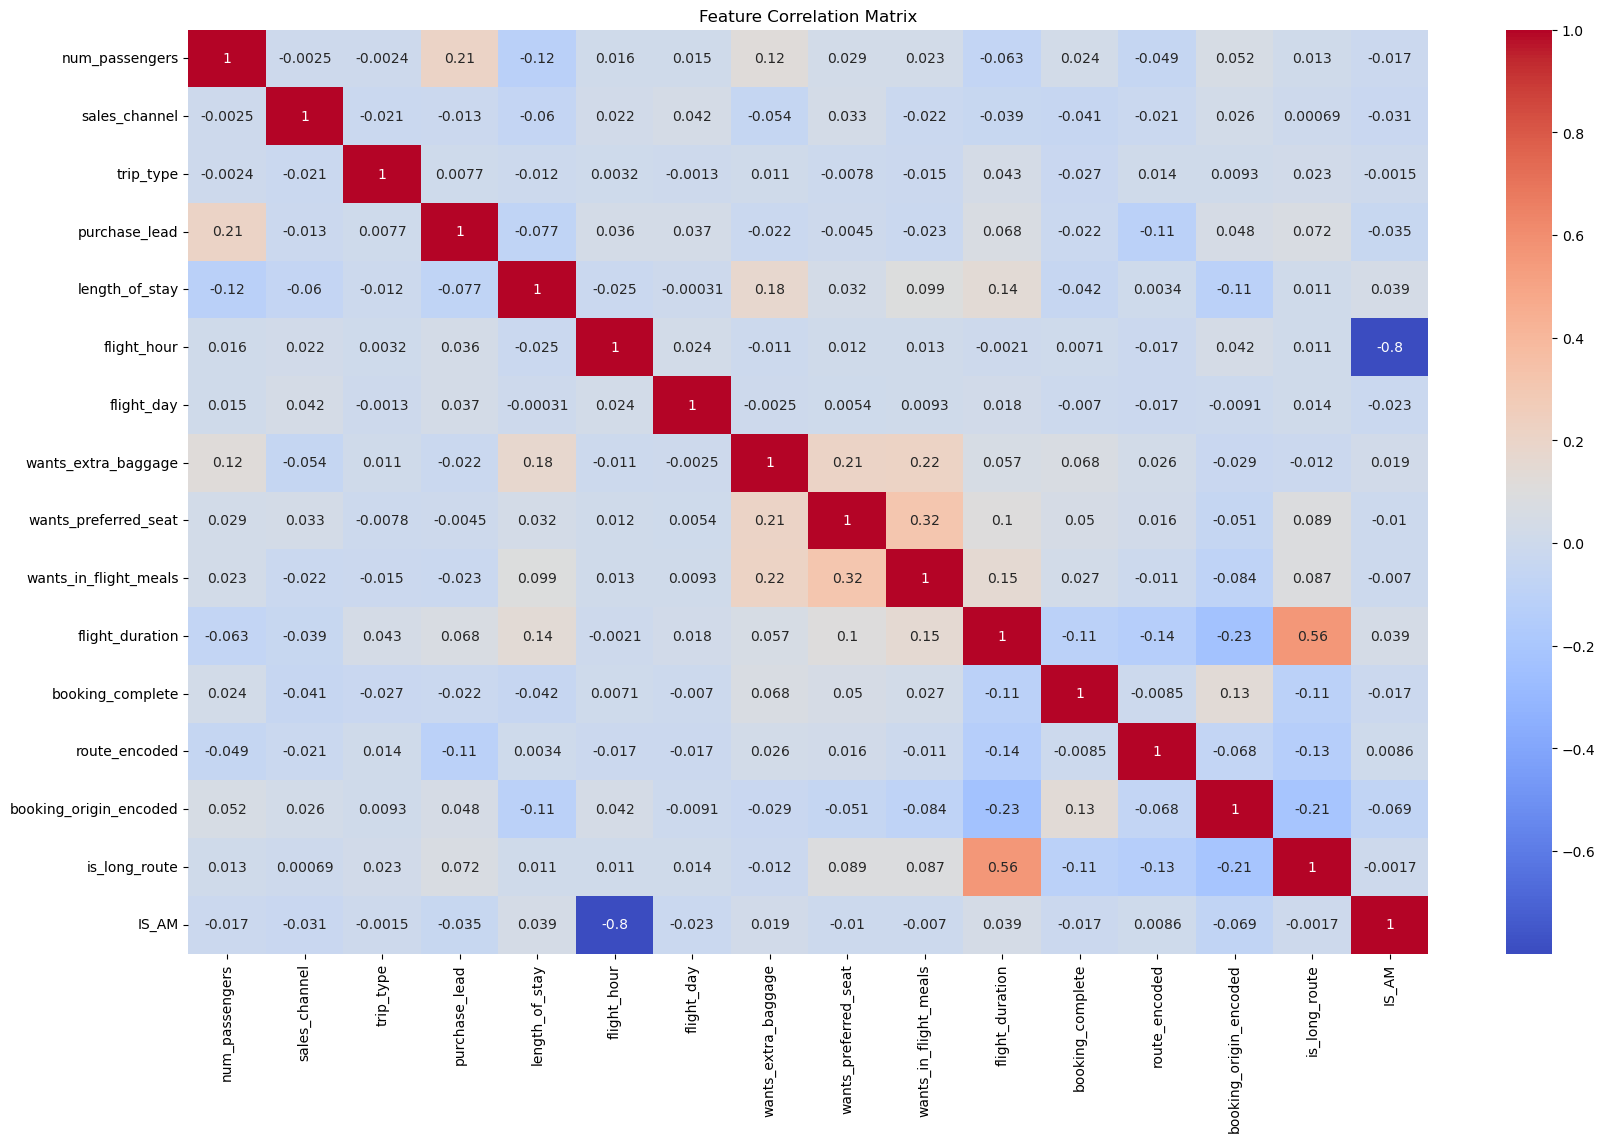

In [23]:

corr = df.select_dtypes(include=np.number).corr()
plt.figure(figsize=(20,12))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()


**Predictive Modeling**

Uses a Random Forest algorithm for classification

In [25]:
# y = output features
y = df['booking_complete']

# X = input features
X = df.drop(['booking_complete', 'route', 'booking_origin','purchase_lead_bin'], axis=1)

X


,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,route_encoded,booking_origin_encoded,is_long_route,IS_AM
0,2,1,1,262,19,7,6,1,0,0,5.52,0,61,1,1
1,1,1,1,112,20,3,6,0,0,0,5.52,0,61,1,1
2,2,1,1,243,22,17,3,1,1,0,5.52,0,36,1,0
3,1,1,1,96,31,4,6,0,0,1,5.52,0,61,1,1
4,2,1,1,68,22,15,3,1,0,1,5.52,0,36,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,2,1,1,27,6,9,6,1,0,1,5.62,720,4,1,1
49996,1,1,1,111,6,4,7,0,0,0,5.62,720,4,1,1
49997,1,1,1,24,6,22,6,0,0,1,5.62,720,4,1,0
49998,1,1,1,15,6,11,1,1,0,1,5.62,720,4,1,1


In [26]:
# Create a training/testing split based on 70%-30% split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Shapes of the resulting sets
print("Train set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Train set shape: (35000, 15) (35000,)
Test set shape: (15000, 15) (15000,)


In [27]:
# Train model with Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42,class_weight='balanced',
    n_estimators=200,
    max_depth=10)
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=200,
                       random_state=42)

In [28]:
#predictions based on test data
rf_preds = rf_model.predict(X_test)

**Model Evaluation**

Reports accuracy, precision, recall, F1-score

---- Random Forest ----
Accuracy: 0.7066666666666667
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.71      0.80     12784
           1       0.29      0.69      0.41      2216

    accuracy                           0.71     15000
   macro avg       0.61      0.70      0.61     15000
weighted avg       0.83      0.71      0.75     15000



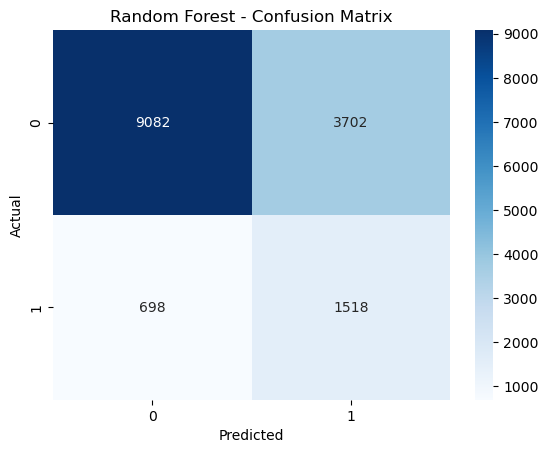

In [30]:
# Evaluate models and check model accuracy
def evaluate_model(name, y_true, y_pred):
    print(f"---- {name} ----")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Model evaluation
evaluate_model("Random Forest", y_test, rf_preds)

In [31]:
# Feature importance 
feature_importances = pd.DataFrame({
    'Feature': rf_model.feature_names_in_,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False).reset_index(drop=True)

feature_importances['Importance'] = feature_importances['Importance'].round(4)

feature_importances

,Feature,Importance
0,booking_origin_encoded,0.3661
1,route_encoded,0.1307
2,length_of_stay,0.1144
3,flight_duration,0.0865
4,purchase_lead,0.0762
5,flight_hour,0.0497
6,wants_extra_baggage,0.0321
7,flight_day,0.0310
8,num_passengers,0.0214
9,sales_channel,0.0214
